In [159]:
######################################################
# Class to process OMB and SIMBA buoy data
#
# Current functionality:
# - reading and parsing text files with buoy positions (OMB and FMI SIMBA)
# - export to GIS ESRI shapefile format
# - plotting buoy tracks on a map (automatically calculated extent, manually defined)
# - putting labels at the end of buoy trajectory
# - plot selected set of buoys by its ID number
# - selection by start and end time
# - label with start date at the begining of buoy trajectory
# - get buoy IDs
# - clean up data from artificial buoy positions based on buoy speed thershold
#
# TODO:
# 
# - ice deformation code
# - export to geojson
# 
#
#######################################################

In [176]:
import glob
import os
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import os
import fiona
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import shapely.geometry as sgeom
from copy import copy
import cartopy.feature as cfeature
import geopandas as gpd
import re
from datetime import datetime
import pyproj
import warnings
warnings.filterwarnings('ignore')

class BUOYtools:
    def __init__(self,
                 buoy_dir='/data/rrs/seaice/drifters_scripts/drift_data/simba',
                 data_type='dat',
                 shp_dir='/data/rrs/seaice/drifters_scripts/drift_data/simba/shp',
                 map_extent=None,
                 start_date_ll = None,
                 end_date_ll = None,
                 buoy_ids=None,
                 start_date=None,
                 end_date=None,
                 clean_data=True,
                 speed_th=10):
        
        self.buoy_dir = buoy_dir
        self.shp_dir = shp_dir
        self.data_type = data_type
        self.map_extent = map_extent
        self.start_date_ll = start_date_ll
        self.end_date_ll = end_date_ll
        self.buoy_ids = buoy_ids
        self.start_date = start_date
        self.end_date = end_date
        self.clean_data = clean_data
        self.speed_th = speed_th
        
        if self.start_date is not None:
            try:
                dt_str = '%s-%s-%s %s:%s:%s' % (self.start_date[0:4], self.start_date[4:6],
                                                self.start_date[6:8], self.start_date[8:10],
                                                self.start_date[10:12], self.start_date[12:14]
                                               )
                self.start_date = datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S')
            except:
                print('The start date must be in the format: YYYYMMDDHHMMSS')
        else:
            pass
        
        if self.end_date is not None:
            try:
                dt_str = '%s-%s-%s %s:%s:%s' % (self.end_date[0:4], self.end_date[4:6],
                                                self.end_date[6:8], self.end_date[8:10],
                                                self.end_date[10:12], self.end_date[12:14]
                                               )
                self.end_date = datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S')
            except:
                print('The start date must be in the format: YYYYMMDDHHMMSS')
        else:
            pass
        
        if data_type is not None:
            ffiles = glob.glob(f'{buoy_dir}/*.{data_type}')
        else:
            ffiles = glob.glob(f'{buoy_dir}/*.*')
            
        for ifile in ffiles:
            # Reformat raw SIMBA data to CSV
            if ifile.find('FMI')>=0 and ifile.endswith('dat'):
                f = open(ifile, 'r')

                csv_path = f'''{buoy_dir}/{os.path.basename(ifile).split('.')[0]}.csv'''
                
                if os.path.isfile(csv_path):
                    #print('### Remove file')
                    os.remove(csv_path)
                else:
                    pass
                
                f_csv = open(csv_path, 'w')
                f_csv.write('# Time,Latitude,Longitude,temp,press\n')

                lines = f.readlines()

                for line in lines:
                    #print(line)
                    try:
                        y, m, d, h, minute,sec, lat, lon, temp, pres = line.split()
                        
                        if self.start_date is not None and self.end_date is None:
                            dt_str = f'{y}-{m}-{d} {h}:{minute}:{sec}'
                            i_dt = datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S')
                            if i_dt>=self.start_date:
                                wr_line = '%s-%s-%s %s:%s:%s,%s,%s,%s,%s\n' % (y, m, d, h, minute, sec, lat, lon, temp, pres)
                                #print(wr_line)
                                f_csv.write(wr_line)
                            else:
                                pass
                        else:
                            pass
                            
                        if self.end_date is not None and self.start_date is None:
                            dt_str = f'{y}-{m}-{d} {h}:{minute}:{sec}'
                            i_dt = datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S')
                            if i_dt<=self.end_date:
                                wr_line = '%s-%s-%s %s:%s:%s,%s,%s,%s,%s\n' % (y, m, d, h, minute, sec, lat, lon, temp, pres)
                                #print(wr_line)
                                f_csv.write(wr_line)
                            else:
                                pass
                        else:
                            pass
                            
                        if self.end_date is not None and self.start_date is not None:
                            dt_str = f'{y}-{m}-{d} {h}:{minute}:{sec}'
                            i_dt = datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S')
                            if i_dt>=self.start_date and i_dt<=self.end_date:
                                wr_line = '%s-%s-%s %s:%s:%s,%s,%s,%s,%s\n' % (y, m, d, h, minute, sec, lat, lon, temp, pres)
                                #print(wr_line)
                                f_csv.write(wr_line)
                            else:
                                pass
                        else:
                            pass
                            
                        if self.end_date is None and self.start_date is None:
                            wr_line = '%s-%s-%s %s:%s:%s,%s,%s,%s,%s\n' % (y, m, d, h, minute, sec, lat, lon, temp, pres)
                            f_csv.write(wr_line)
                        else:
                            pass
                    except:
                        pass
                f_csv.close()
                f.close()
            else:
                pass
            
    def csv2shp(self):
        ''' Convert CSV files to shp'''

        # Create a directory 
        os.makedirs(self.shp_dir, exist_ok=True)
        self.shp_files = []

        for file in os.listdir(self.buoy_dir):
            if file.endswith('csv') or file.endswith('txt'):
                filename = os.fsdecode(file)
                b_id = re.findall(r'\d+', filename)[0]
                
                if self.buoy_ids is not None:
                    if int(b_id) in self.buoy_ids:
                        input_file = f'{self.buoy_dir}/{filename}'

                        #Reading your csv file with pandas
                        df = pd.read_csv(input_file)  
                        
                        # Convert first column to datetime type
                        df['# Time'] = pd.to_datetime(df['# Time'])
                        
                        # Filter data by start and end date
                        if self.start_date is not None and self.end_date is None:
                            df = df[df['# Time']>=self.start_date]
                        else:
                            pass
                            
                        if self.end_date is not None and self.start_date is None:
                            df = df[df['# Time']<=self.end_date]
                        else:
                            pass
                            
                        if self.start_date is not None and self.end_date is not None:
                            df = df[(df['# Time']>=self.start_date) & (df['# Time']<=self.end_date)]
                        else:
                            pass
                        
                        # Clean data by buoy speed threshold
                        # TODO: need to be more advanced iterating after dropping a row
                        if self.clean_data:
                            print(f'Filtering data {filename} by speed threshold of {self.speed_th}')
                            speed_th = 10 # m/s
                            geod = pyproj.Geod(ellps='WGS84')
                            
                            for row in df.index[1:]:
                                try:
                                    # Calculate distance
                                    lon0 = df.Longitude[row-1]
                                    lat0 = df.Latitude[row-1]
                                    lon1 = df.Longitude[row]
                                    lat1 = df.Latitude[row]
                                    azimuth1, azimuth2, distance = geod.inv(lon0, lat0, lon1, lat1)

                                    # Calculate time difference
                                    if type(df['# Time'][row]) is str:
                                        idt1 = datetime.strptime(df['# Time'][row], '%Y-%m-%d %H:%M:%S')
                                        idt0 = datetime.strptime(df['# Time'][row-1], '%Y-%m-%d %H:%M:%S')
                                    else:
                                        idt1 = df['# Time'][row]
                                        idt0 = df['# Time'][row-1]

                                    t_diff = (idt1-idt0).total_seconds()

                                    if t_diff > 5:
                                        speed = distance / t_diff 
                                        if speed > speed_th:
                                            df.drop(row, inplace=True)
                                            #print(f'dropping data for speed of {speed} m/s')
                                        else:
                                            pass
                                    else:
                                        df.drop(row, inplace=True)
                                        #print(f'dropping data for time diff. of {t_diff} s')
                                except:
                                    pass
                        else:
                            pass
                        

                        # Create tuples of geometry by zipping Longitude and latitude columns in your csv file
                        geometry = [Point(xy) for xy in zip(df.Longitude, df.Latitude)] 

                        # Define coordinate reference system on which to project your resulting shapefile
                        crs = {'init': 'epsg:4326'}

                        # Convert pandas object (containing your csv) to geodataframe object using geopandas
                        gdf = GeoDataFrame(df, crs = crs, geometry=geometry)

                        # Save file to local destination
                        output_filename = f'''{self.shp_dir}/{filename.split('.')[0]}.shp'''
                        df['# Time'] = df['# Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
                        gdf.to_file(filename= output_filename, driver='ESRI Shapefile')
                        self.shp_files.append(output_filename)
                else:
                    input_file = f'{self.buoy_dir}/{filename}'

                    #Reading your csv file with pandas
                    df = pd.read_csv(input_file)          

                    # Create tuples of geometry by zipping Longitude and latitude columns in your csv file
                    geometry = [Point(xy) for xy in zip(df.Longitude, df.Latitude)] 

                    # Define coordinate reference system on which to project your resulting shapefile
                    crs = {'init': 'epsg:4326'}

                    # Convert pandas object (containing your csv) to geodataframe object using geopandas
                    gdf = GeoDataFrame(df, crs = crs, geometry=geometry)

                    # Save file to local destination
                    output_filename = f'''{self.shp_dir}/{filename.split('.')[0]}.shp'''
                    gdf.to_file(filename= output_filename, driver='ESRI Shapefile')
                    self.shp_files.append(output_filename)      
        
        # Get data bounds from shapefile
        self.get_bounds()
    
    # Map functions
    def find_side(self, ls, side):
        """
        Given a shapely LineString which is assumed to be rectangular, return the
        line corresponding to a given side of the rectangle.

        """
        minx, miny, maxx, maxy = ls.bounds
        points = {'left': [(minx, miny), (minx, maxy)],
                  'right': [(maxx, miny), (maxx, maxy)],
                  'bottom': [(minx, miny), (maxx, miny)],
                  'top': [(minx, maxy), (maxx, maxy)],}
        return sgeom.LineString(points[side])


    def lambert_xticks(self, ax, ticks):
        """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
        te = lambda xy: xy[0]
        lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
        xticks, xticklabels = self._lambert_ticks(ax, ticks, 'bottom', lc, te)
        ax.xaxis.tick_bottom()
        ax.set_xticks(xticks)
        ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])


    def lambert_yticks(self, ax, ticks):
        """Draw ricks on the left y-axis of a Lamber Conformal projection."""
        te = lambda xy: xy[1]
        lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
        yticks, yticklabels = self._lambert_ticks(ax, ticks, 'left', lc, te)
        ax.yaxis.tick_left()
        ax.set_yticks(yticks)
        ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

    def _lambert_ticks(self, ax, ticks, tick_location, line_constructor, tick_extractor):
        """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
        outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
        axis = self.find_side(outline_patch, tick_location)
        n_steps = 30
        extent = ax.get_extent(ccrs.PlateCarree())
        _ticks = []
        for t in ticks:
            xy = line_constructor(t, n_steps, extent)
            proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
            xyt = proj_xyz[..., :2]
            ls = sgeom.LineString(xyt.tolist())
            locs = axis.intersection(ls)
            if not locs:
                tick = [None]
            else:
                tick = tick_extractor(locs.xy)
            _ticks.append(tick[0])
        # Remove ticks that aren't visible:    
        ticklabels = copy(ticks)
        while True:
            try:
                index = _ticks.index(None)
            except ValueError:
                break
            _ticks.pop(index)
            ticklabels.pop(index)
        return _ticks, ticklabels

    def plot_tracks(self,
                    proj = ccrs.NorthPolarStereo,
                    extent = None,
                    centr_mer = 0,
                    linewidth = 1,
                    markersize = 2,
                    markerscale = 6,
                    shp_path = None,
                    xticks=None,
                    yticks=None,
                    add_coastline=True,
                    plot_start_date=True,
                    plot_end_date=True,
                    out_png_filename='plot.png',
                    dpi=600,
                    end_date_ll=None):

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8),
                               subplot_kw={'projection': proj(central_longitude=centr_mer)})

        # Set map extent
        if self.map_extent is None:
            if hasattr(self, 'minx') and hasattr(self, 'miny') and hasattr(self, 'maxx') and hasattr(self, 'maxy'):
                # x0, x1, y0, y1
                ax.set_extent([self.minx, self.maxx, self.miny, self.maxy], crs=ccrs.PlateCarree())
            else:
                print('The map bounds have not been calculated!')
        else:
            print('Plotting with defined extent')
            ax.set_extent(self.map_extent, crs=ccrs.PlateCarree())

        # *must* call draw in order to get the axis boundary used to add ticks:
        fig.canvas.draw()

        # Define gridline locations and draw the lines using cartopy's built-in gridliner
        if xticks is None:
            xticks = list(range(-180, 180, 5))
        else:
            pass
        if yticks is None:
            yticks = list(np.arange(0, 90, 1))
        else:
            pass
        
        ax.gridlines(xlocs=xticks, ylocs=yticks, linewidth=linewidth)

        # Label the end-points of the gridlines using the custom tick makers:
        ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
        ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
        self.lambert_xticks(ax, xticks)
        self.lambert_yticks(ax, yticks)

        # Add coastline
        if add_coastline==True:
            ax.coastlines(resolution='10m', alpha=0.2)
            ax.add_feature(cfeature.LAND, edgecolor='none', alpha=0.2)
        else:
            pass

        # Plot drift buoy track
        for shp_file in self.shp_files:
            gdf = gpd.read_file(shp_file)
            gdf = gdf.to_crs(proj(central_longitude=centr_mer).proj4_init)
            label=re.findall(r'\d+', shp_file)[0]
            gdf.plot(ax=ax, linewidth=linewidth, markersize=markersize,label=label, alpha=1)

            # Plot start or/and date
            if plot_start_date:
                if self.start_date_ll is not None:
                    if int(label) in self.start_date_ll:
                        x = gdf.geometry.x[0]
                        y = gdf.geometry.y[0]
                        idate = gdf['# Time'][0]
                        ax.annotate(idate, xy=(x, y), xytext=(3, -3), textcoords="offset points")
                    else:
                        pass
                else:
                    x = gdf.geometry.x[0]
                    y = gdf.geometry.y[0]
                    idate = gdf['# Time'][0]
                    ax.annotate(idate, xy=(x, y), xytext=(3, -3), textcoords="offset points")
            else:
                pass
            
            
            if plot_end_date:
                if self.end_date_ll is not None:
                    if int(label) in self.end_date_ll:
                        x = gdf.geometry.x[len(gdf['# Time'])-1]
                        y = gdf.geometry.y[len(gdf['# Time'])-1]
                        idate = gdf['# Time'][len(gdf['# Time'])-1]
                        ax.annotate(idate, xy=(x, y), xytext=(3, -3), textcoords="offset points")
                    else:
                        pass
                else:
                    x = gdf.geometry.x[len(gdf['# Time'])-1]
                    y = gdf.geometry.y[len(gdf['# Time'])-1]
                    idate = gdf['# Time'][len(gdf['# Time'])-1]
                    ax.annotate(idate, xy=(x, y), xytext=(3, -3), textcoords="offset points")
            else:
                pass
            
            gdf = None

        # Add legend
        fig.legend(bbox_to_anchor=(0.89, 0.33), loc='center right', markerscale=markerscale)
        fig.savefig(out_png_filename, bbox_inches='tight', dpi=dpi)
        
    def get_bounds(self, delta=0.1):
        ''' Get bounds from all shapefiles:
            minx, miny, maxx, maxy '''
        
        f1 = gpd.read_file(self.shp_files[0])
        minx, miny, maxx, maxy = f1.total_bounds
        
        for ifile in self.shp_files[1:]:
            f = gpd.read_file(ifile)
            iminx, iminy, imaxx, imaxy = f.total_bounds            
            if iminx<minx:
                minx = iminx
            if iminy<miny and miny>70:
                miny = iminy
            if imaxx>maxx:
                maxx = imaxx
            if imaxy>maxy:
                maxy = imaxy
        self.minx = minx - delta
        self.miny = miny - delta
        self.maxx = maxx + delta
        self.maxy = maxy + delta
        
    def get_buoy_ids(self):
        ''' Get buoy ids '''
        if self.buoy_ids is not None:
            return self.buoy_ids
        else:
            b_ids_ll = []
            for ifile in glob.glob(f'{self.buoy_dir}/*.*'):
                filename = os.fsdecode(ifile)
                try:
                    b_id = re.findall(r'\d+', filename)[0]
                    b_ids_ll.append(int(b_id))
                except:
                    pass
            self.buoy_ids = set(b_ids_ll)
            return self.buoy_ids

Filtering data drifter_206810_coords.txt by speed threshold of 10


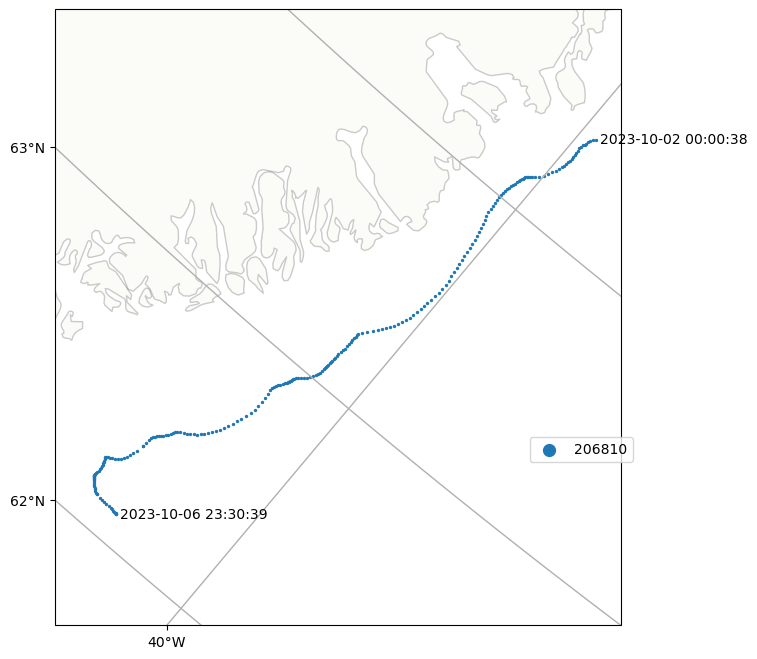

In [177]:
# Initialize buoy data
b = BUOYtools(buoy_dir='/data/rrs/seaice/drifters_scripts/drift_data/test/text_files',
              shp_dir='/data/rrs/seaice/drifters_scripts/drift_data/test/shp',
              start_date_ll=[206810],
              end_date_ll=[206810],
              buoy_ids=[206810],
              start_date='20231002000000',
              end_date='20231007000000')


# Convert CSV files to shapefile format
b.csv2shp()

# Plot buoy trajectories
b.plot_tracks(out_png_filename='/home/denis/test2.png', plot_end_date=True)

# map_extent = [1, 17, 78, 80.5]
#buoy_ids=[1002,1001, 1003, 206810]

In [178]:
# Initialize buoy data
b = BUOYtools(buoy_dir='/data/rrs/seaice/drifters_scripts/drift_data/test/text_files',
              shp_dir='/data/rrs/seaice/drifters_scripts/drift_data/test/shp',
              start_date_ll=[206810],
              end_date_ll=[206810],
              buoy_ids=None,
              start_date='20231002000000',
              end_date='20231007000000')

In [179]:
# Get buoy IDs
b.get_buoy_ids()

{1001, 1002, 1003, 206795, 206810, 206817, 209056, 209064, 209584, 209591}

Filtering data drifter_209056_coords.txt by speed threshold of 10
Filtering data drifter_206817_coords.txt by speed threshold of 10
Filtering data drifter_209064_coords.txt by speed threshold of 10
Filtering data FMI1001GPS_final.csv by speed threshold of 10
Filtering data FMI1002GPS_final.csv by speed threshold of 10
Filtering data drifter_206795_coords.txt by speed threshold of 10
Filtering data FMI1003GPS_final.csv by speed threshold of 10
Filtering data drifter_209584_coords.txt by speed threshold of 10
Filtering data drifter_209591_coords.txt by speed threshold of 10
Filtering data drifter_206810_coords.txt by speed threshold of 10


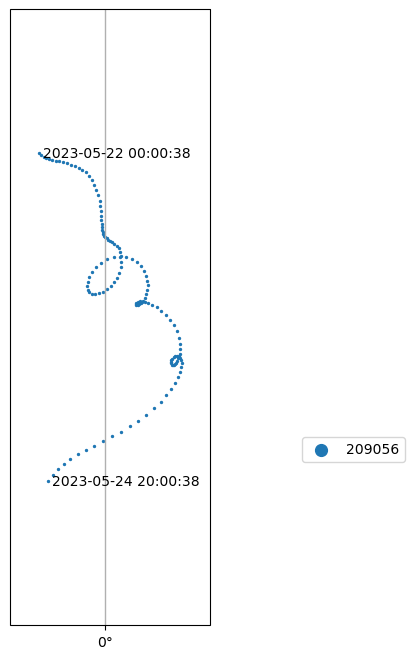

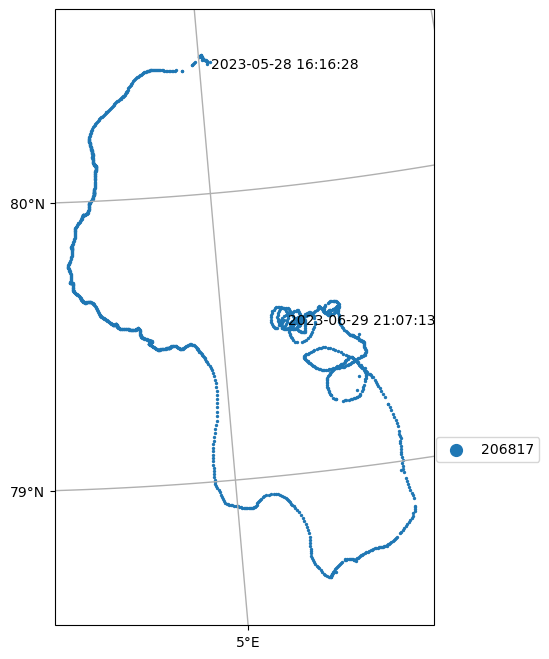

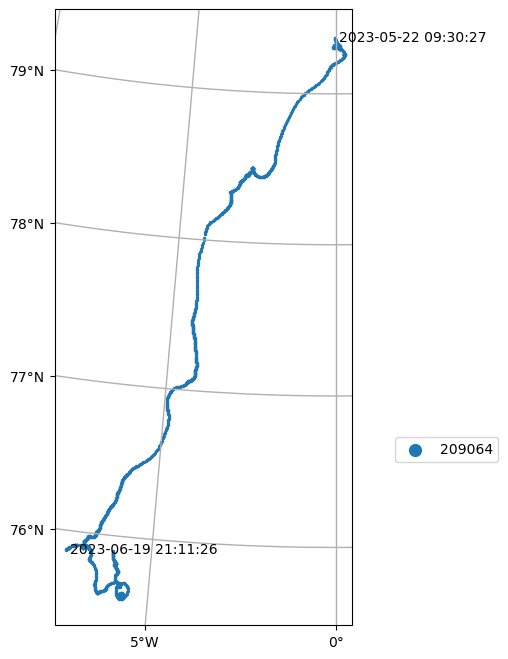

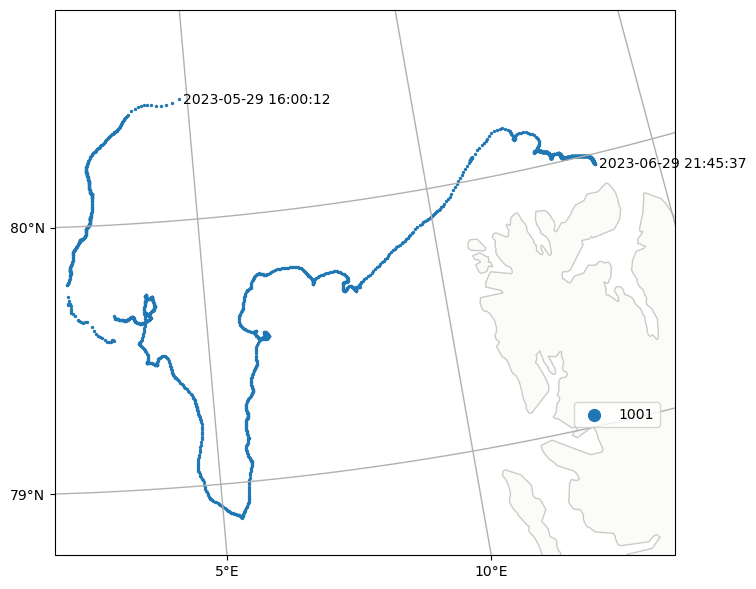

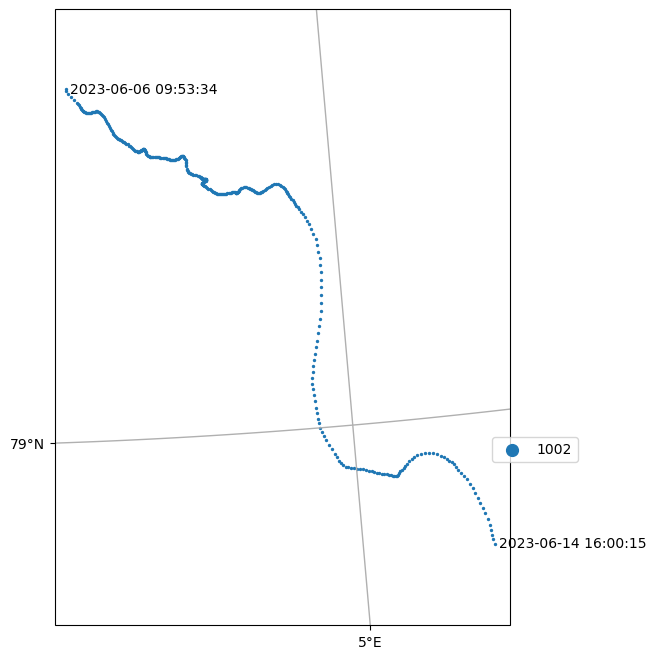

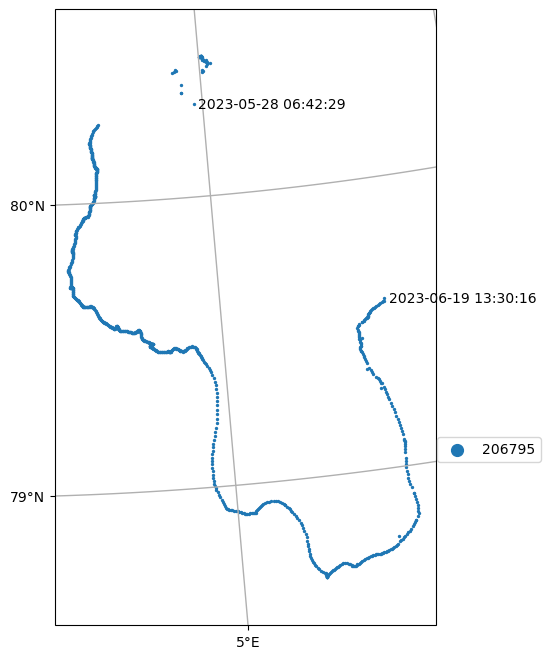

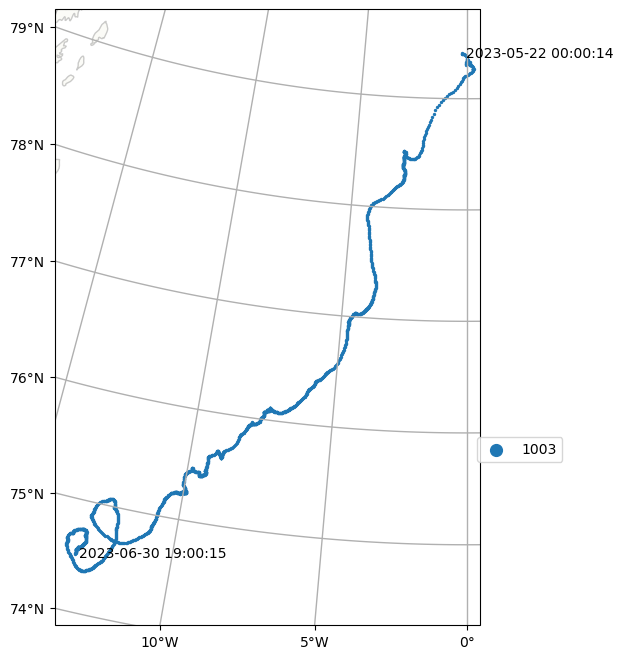

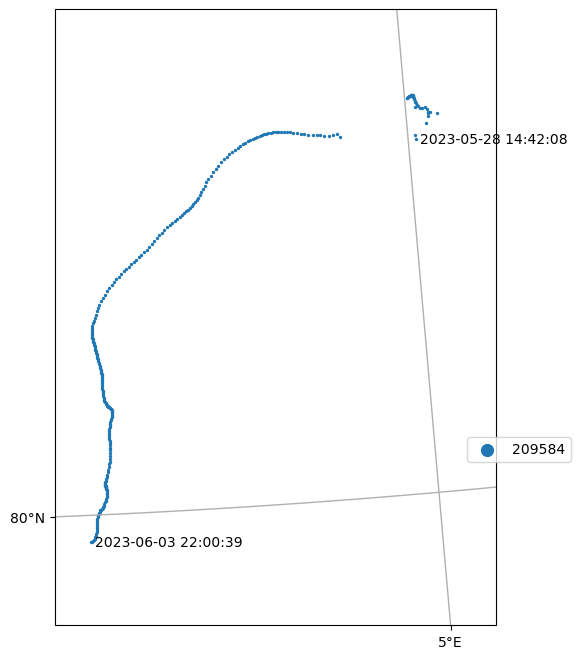

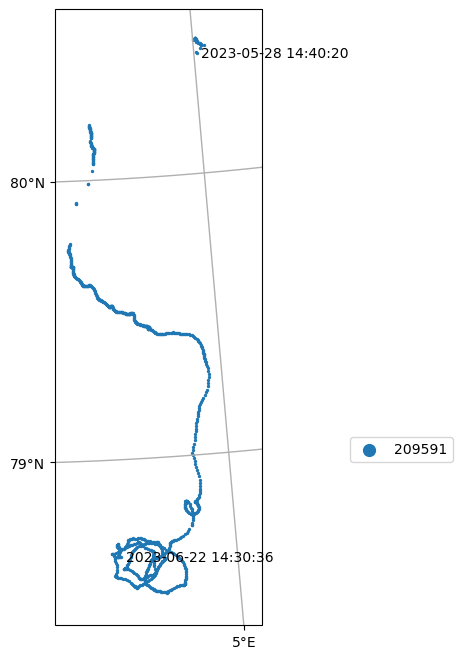

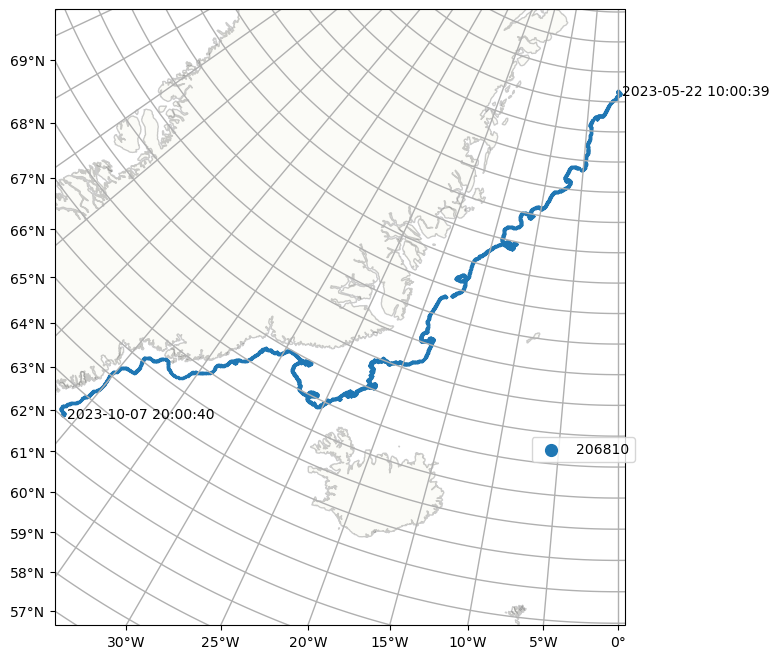

In [180]:
# Plot individual buoy tracks

# Initialize buoy data
b = BUOYtools(buoy_dir='/data/rrs/seaice/drifters_scripts/drift_data/test/text_files',
              shp_dir='/data/rrs/seaice/drifters_scripts/drift_data/test/shp',
              buoy_ids=None)

for b_id in b.get_buoy_ids():
    b1 = BUOYtools(buoy_dir='/data/rrs/seaice/drifters_scripts/drift_data/test/text_files',
                   shp_dir='/data/rrs/seaice/drifters_scripts/drift_data/test/shp',
                   start_date_ll=[b_id],
                   end_date_ll=[b_id],
                   buoy_ids=[b_id],
                   start_date='20230522000000')

    # Convert CSV files to shapefile format
    b1.csv2shp()

    # Plot buoy trajectories
    b1.plot_tracks(out_png_filename=f'/data/rrs/seaice/drifters_scripts/plots/{b_id}.png',
                  plot_start_date=True,
                  plot_end_date=True)